# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [2]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [3]:
asl.df.ix[98,1]  # look at the data available for an individual frame

C:\Anaconda\envs\aind\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [4]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [5]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [6]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [7]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['GIRL', 'TEACHER', 'WRITE', 'CHICAGO', 'FINISH', 'LEG', 'CHICKEN', 'GROUP', 'TOY1', 'NAME', 'THROW', 'YESTERDAY', 'CAR', 'HIT', 'BUT', 'WHAT', 'PAST', 'PUTASIDE', 'MANY', 'PEOPLE', 'GET', 'FIND', 'HOUSE', 'BROCCOLI', 'LIVE', 'FRIEND', 'WANT', 'CHINA', 'BUY', 'MAN', 'STOLEN', 'NEW', 'SAY', 'BROTHER', 'KNOW', 'SOMETHING-ONE', 'BOX', 'POTATO', 'FUTURE1', 'STUDENT', 'JOHN', 'EAT', 'BOOK', 'GIVE2', 'HERE', 'SHOOT', 'CHOCOLATE', 'FUTURE', 'IX', 'WHO', 'LOVE', 'GIVE', 'SHOULD', 'SAY-1P', 'SUE', 'JANA', 'WILL', 'OLD', 'APPLE', 'FISH', 'NEW-YORK', 'SELF', 'BLAME', 'WOMAN', 'PARTY', 'CAN', 'PREFER', 'POSS', 'SEE', 'COAT', 'LEAVE', 'NOT', 'HOMEWORK', 'FRANK', 'LAST-WEEK', 'WONT', 'TELL', 'GO1', 'GO', 'FRED', 'SEARCH-FOR', 'TOMORROW', 'CORN', 'IX-1P', 'DECIDE', 'GIVE1', 'GIVE3', 'VEGETABLE', 'READ', 'CANDY', 'BUY1', 'CORN1', 'NEXT-WEEK', 'BLUE', 'SELL', 'ANN', 'BREAK-DOWN', 'MOVIE', 'HAVE', 'VIDEOTAPE', 'BILL', 'ALL', 'TOY', 'ARRIVE', 'MARY', 'BORROW', 'GO2', 'LIKE', 'BOY', 'THINK

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [8]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [9]:
df_means = asl.df.groupby('speaker').mean()
df_means

left-x      left-y     right-x     right-y      nose-x  \
speaker                                                               
man-1    206.248203  218.679449  155.464350  150.371031  175.031756   
woman-1  164.661438  161.271242  151.017865  117.332462  162.655120   
woman-2  183.214509  176.527232  156.866295  119.835714  170.318973   

            nose-y    grnd-ry    grnd-rx     grnd-ly    grnd-lx  
speaker                                                          
man-1    61.642600  88.728430 -19.567406  157.036848  31.216447  
woman-1  57.245098  60.087364 -11.637255  104.026144   2.006318  
woman-2  58.022098  61.813616 -13.452679  118.505134  12.895536

To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [10]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [11]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


left-x     left-y    right-x    right-y    nose-x    nose-y  \
speaker                                                                   
man-1    15.154425  36.328485  18.901917  54.902340  6.654573  5.520045   
woman-1  17.573442  26.594521  16.459943  34.667787  3.549392  3.538330   
woman-2  15.388711  28.825025  14.890288  39.649111  4.099760  3.416167   

           grnd-ry    grnd-rx    grnd-ly    grnd-lx  left-x-mean  
speaker                                                           
man-1    53.487999  20.269032  36.572749  15.080360          0.0  
woman-1  33.972660  16.764706  27.117393  17.328941          0.0  
woman-2  39.128572  16.191324  29.320655  15.050938          0.0

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [12]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
features_pos = ['right-x', 'right-y', 'left-x', 'left-y']

for norm, pos in zip(features_norm, features_pos):
    pos_mean = asl.df['speaker'].map(df_means[pos])
    pos_std = asl.df['speaker'].map(df_std[pos])
    asl.df[norm] = (asl.df[pos] - pos_mean) / pos_std

In [13]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

grnd_rx, grnd_ry = asl.df['grnd-rx'], asl.df['grnd-ry']
grnd_lx, grnd_ly = asl.df['grnd-lx'], asl.df['grnd-ly']

asl.df['polar-rr'] = np.hypot(grnd_rx, grnd_ry)
asl.df['polar-lr'] = np.hypot(grnd_lx, grnd_ly)
asl.df['polar-rtheta'] = np.arctan2(grnd_rx, grnd_ry)
asl.df['polar-ltheta'] = np.arctan2(grnd_lx, grnd_ly)

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [14]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [19]:
df_std = asl.df.groupby('speaker').std()
df_means = asl.df.groupby('speaker').mean()

# Nomalize Grounded Features
features_norm_grnd = ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx','norm-grnd-ly']
features_grnd = ['grnd-rx', 'grnd-ry', 'grnd-lx','grnd-ly']

for norm_grnd, grnd in zip(features_norm_grnd, features_grnd):
    asl.df[norm_grnd] = (asl.df[grnd] - asl.df['speaker'].map(df_means[grnd])) / asl.df['speaker'].map(df_std[grnd])
    
# Add Delta Values
features_delta_norm_grnd = ['delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly']
asl.df[features_delta_norm_grnd] = asl.df[features_norm_grnd].diff().fillna(0)

# Nomalize Polar coordinates
features_norm_polar = ['norm-rr', 'norm-rtheta', 'norm-lr','norm-ltheta']
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

for norm_polar, polar in zip(features_norm_polar, features_polar):
    asl.df[norm_polar] = (asl.df[polar] - asl.df['speaker'].map(df_means[polar])) / asl.df['speaker'].map(df_std[polar])

# Add Delta Values
features_delta_norm_polar = ['delta-norm-polar-rr', 'delta-norm-polar-rtheta', 'delta-norm-polar-lr', 'delta-norm-polar-ltheta']
asl.df[features_delta_norm_polar] = asl.df[features_norm_polar].diff().fillna(0)

# Define 'features_custom'
features_custom = features_norm_grnd + features_delta_norm_grnd + features_norm_polar + features_delta_norm_polar
features_custom

['norm-grnd-rx',
 'norm-grnd-ry',
 'norm-grnd-lx',
 'norm-grnd-ly',
 'delta-norm-grnd-rx',
 'delta-norm-grnd-ry',
 'delta-norm-grnd-lx',
 'delta-norm-grnd-ly',
 'norm-rr',
 'norm-rtheta',
 'norm-lr',
 'norm-ltheta',
 'delta-norm-polar-rr',
 'delta-norm-polar-rtheta',
 'delta-norm-polar-lr',
 'delta-norm-polar-ltheta']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** I thought it is natural that train the hand movements based on the person doing sign language. So I normalized the ground features, and applied the delta difference as above. Also, the same processes is applied for the polar coordinates. The polar coordinates may give some other informations that ground features can't give us.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [20]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.131s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [21]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433187


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [22]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [-1.12415027 69.44164191 17.02866283 77.7231196 ]
variance =  [19.70434594 16.83041492 30.51552305 11.03678246]

hidden state #1
mean =  [-11.45300909  94.109178    19.03512475 102.2030162 ]
variance =  [ 77.403668   203.35441965  26.68898447 156.12444034]

hidden state #2
mean =  [-3.46504869 50.66686933 14.02391587 52.04731066]
variance =  [49.12346305 43.04799144 39.35109609 47.24195772]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [32]:
test_words = ['ALL', 'CHOCOLATE', 'YESTERDAY']
features = [features_ground, features_norm_grnd, features_delta_norm_grnd, features_norm_polar, features_delta_norm_polar, features_custom]
features_name = ['Ground', 'Normalized Ground', 'Delta of Normalized Ground', 'Normalized Polar', 'Delta of Normalized Polar', 'Custom']
num_hidden_states = [2,3,4]

for word in test_words:
    for idx, feature in enumerate(features):
        for num in num_hidden_states:
            model, logL = train_a_word(word,num, feature)
            show_model_stats(word, model)
            print("Feature: {}, Word: {}, {} hidden states: logL = {}\n".format(features_name[idx], word, num, logL))


Number of states trained in model for ALL is 2
hidden state #0
mean =  [-45.01893004  17.3427856   26.0190014  179.276369  ]
variance =  [166.90117523  43.26109954  10.44081841  21.88928818]

hidden state #1
mean =  [-74.056617    34.60145709  26.61673627 180.3166745 ]
variance =  [158.70140931  36.86187618  45.43079238   1.09355741]

Feature: Ground, Word: ALL, 2 hidden states: logL = -287.0098200389338

Number of states trained in model for ALL is 3
hidden state #0
mean =  [-67.00010712  38.59997686  31.69995974 179.80004591]
variance =  [32.80088744  6.64130853  2.0109396   0.96088721]

hidden state #1
mean =  [-41.23514926  16.51458103  26.81887957 178.51358133]
variance =  [92.75874885 44.23348763  7.21043514 21.27413749]

hidden state #2
mean =  [-83.31632702  27.1533751   18.56656316 181.56619811]
variance =  [164.42988776  18.68400265   3.95864007   1.0929442 ]

Feature: Ground, Word: ALL, 3 hidden states: logL = -241.47656488279608

Number of states trained in model for ALL is

Number of states trained in model for ALL is 3
hidden state #0
mean =  [-3.50448874e+00 -1.16153961e+00 -9.16188128e-01  6.60687318e-01
 -2.36814467e-01 -5.23481907e-02 -6.63114135e-02  2.89029911e-13
 -2.01887242e-02 -2.54824136e+00  6.04435931e-01 -7.02873241e-01
  7.05460685e-02 -1.43115428e-01 -3.12608049e-03 -3.36694698e-02]
variance =  [0.09799992 0.00488015 0.00481421 0.00211962 0.25163875 0.00555125
 0.00903553 0.00229905 0.01796723 0.00955236 0.00219382 0.00265412
 0.03824369 0.0278724  0.00230604 0.00386422]

hidden state #1
mean =  [-2.31772533e+00 -9.43308843e-01 -2.64095255e-02  6.25390298e-01
 -2.24256123e-02 -3.39923320e-03  1.20566207e-02 -2.48570564e-03
 -3.80086558e-01 -1.93123199e+00  6.19651829e-01 -2.47093763e-01
  5.41695523e-03 -1.62637339e-02 -1.46856530e-03  6.94535734e-03]
variance =  [0.07851787 0.00339337 0.04313678 0.00165054 0.09135208 0.00299473
 0.00795915 0.0023302  0.01554    0.0053712  0.00158535 0.01210265
 0.0147642  0.01401013 0.00271224 0.00247469

Number of states trained in model for CHOCOLATE is 2
hidden state #0
mean =  [-0.12117898  0.49459277 -0.73183347 -0.25704058]
variance =  [0.06305332 0.03911197 0.16733782 0.0399023 ]

hidden state #1
mean =  [-0.28836013  0.51105036 -1.77499983 -0.36220336]
variance =  [0.01644149 0.12903935 0.02028006 0.04435363]

Feature: Normalized Polar, Word: CHOCOLATE, 2 hidden states: logL = 5.073549181950772

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [-0.00892579  0.57001662 -0.85620942 -0.25997993]
variance =  [0.02685728 0.0121504  0.02703956 0.04334482]

hidden state #1
mean =  [-0.43567333  0.37225216 -0.32965362 -0.29811062]
variance =  [0.01187406 0.05490274 0.25105733 0.01524059]

hidden state #2
mean =  [-0.26057161  0.48991141 -1.754827   -0.33867755]
variance =  [0.02935861 0.13162366 0.02613229 0.05371838]

Feature: Normalized Polar, Word: CHOCOLATE, 3 hidden states: logL = 38.85569423161987

Number of states trained in model for CHOCOLATE is 4
hi

Number of states trained in model for YESTERDAY is 4
hidden state #0
mean =  [-30.80769231  18.46153846  19.15384615  64.96153846]
variance =  [ 8.6941716  48.63352071 67.36133136 30.19121302]

hidden state #1
mean =  [-20.21568627  16.58823529  -5.39215686 124.62745098]
variance =  [ 78.95367551  17.92868512 145.45425221  10.90061899]

hidden state #2
mean =  [-27.14826467  24.56972605  31.363436   164.65425785]
variance =  [ 83.80421892  31.48040973  36.91043754 403.70934148]

hidden state #3
mean =  [-24.6673677   40.94525401  61.36004835 103.28414686]
variance =  [  1.29660177  14.28005294  62.87503199 114.13191424]

Feature: Ground, Word: YESTERDAY, 4 hidden states: logL = -1535.2577097073404

Number of states trained in model for YESTERDAY is 2
hidden state #0
mean =  [-0.88198877 -1.12793539  1.2857835  -1.44930247]
variance =  [0.18789338 0.05435516 0.45112635 0.05437806]

hidden state #1
mean =  [-0.4519656  -1.23594009 -0.3545149   0.4920664 ]
variance =  [0.25239123 0.016224

Number of states trained in model for YESTERDAY is 3
hidden state #0
mean =  [ 0.13132043 -1.14110401 -0.3074888   0.39355336 -0.18362344 -0.05680025
 -0.05891868  0.03698765 -1.30811538 -0.3883645   0.37767376 -0.34165727
 -0.03342057 -0.33890249  0.03691847 -0.05279757]
variance =  [0.15211458 0.00991403 0.42275213 0.29329787 0.04599598 0.00571356
 0.01208672 0.01719466 0.018977   0.4351358  0.34899476 0.15353532
 0.01053924 0.10054173 0.01701941 0.00792631]

hidden state #1
mean =  [-0.75885628 -1.29116212 -0.39637354  0.59787189 -0.05254599 -0.0142415
 -0.00733518  0.00314334 -1.13679156 -1.81924166  0.5972652  -0.45936077
  0.01010145 -0.08922168  0.0027474  -0.00385663]
variance =  [0.04491389 0.0115518  0.30708747 0.02739636 0.03514363 0.00292712
 0.01632741 0.00207586 0.00978566 0.08790437 0.03511832 0.1190261
 0.00504852 0.07071513 0.00263828 0.0063739 ]

hidden state #2
mean =  [-0.84663763 -1.12532381  1.21599329 -1.41154303  0.02282751 -0.04622077
  0.0335793   0.01785789 -

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [33]:
%matplotlib inline

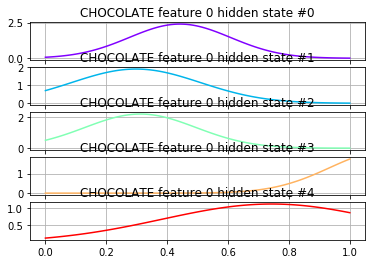

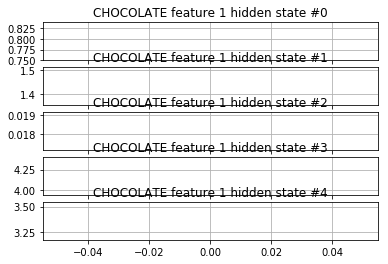

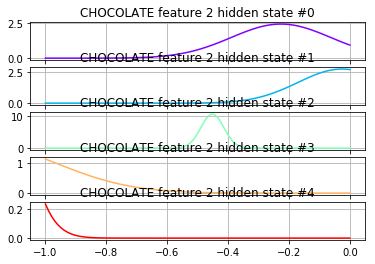

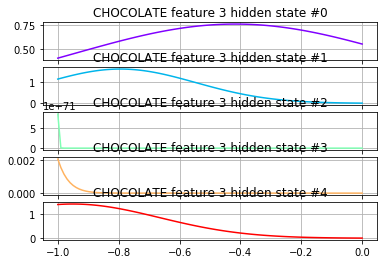

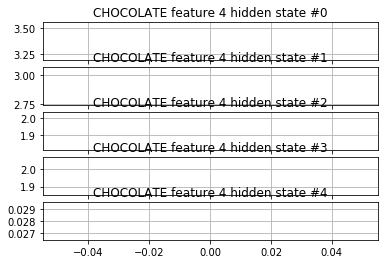

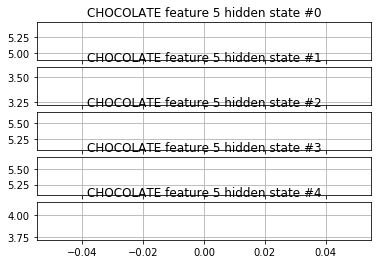

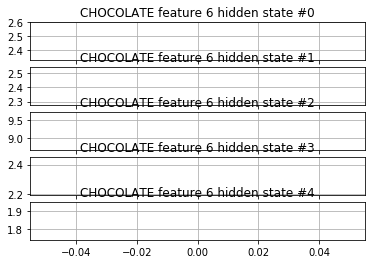

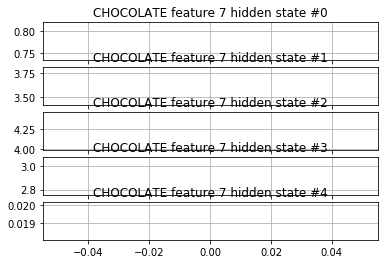

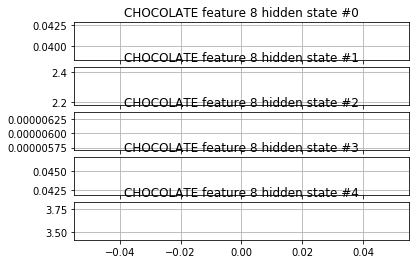

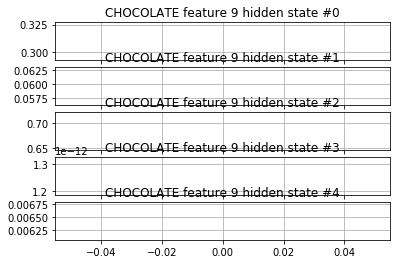

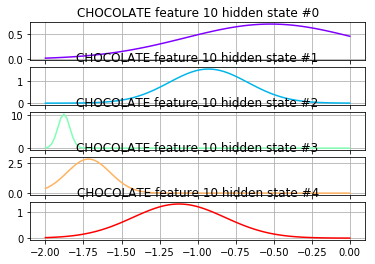

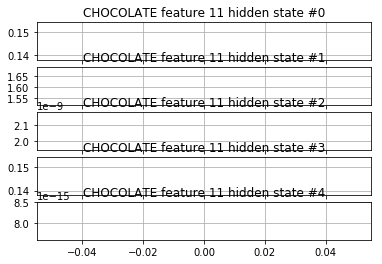

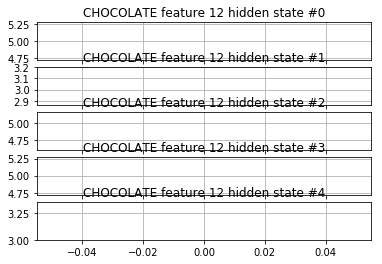

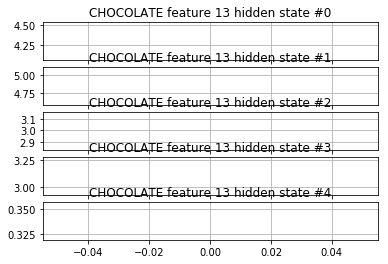

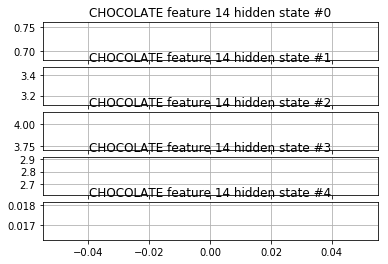

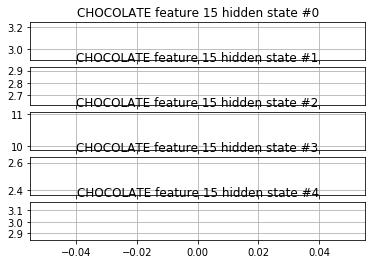

In [39]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()

my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 5, features_custom)
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [46]:
from my_model_selectors import SelectorConstant
test_words = ['ALL', 'CHOCOLATE', 'VEGETABLE']
features = [features_ground, features_delta_norm_grnd, features_delta_norm_polar, features_custom]
features_name = ['Ground', 'Delta of Normalized Ground', 'Delta of Normalized Polar', 'Custom']

for idx, feature in enumerate(features):
    for word in test_words:
        training = asl.build_training(feature)
        model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
        print("Features: {}, Number of states trained in model for {} is {}".format(features_name[idx], word, model.n_components))
    print("")

Features: Ground, Number of states trained in model for ALL is 3
Features: Ground, Number of states trained in model for CHOCOLATE is 3
Features: Ground, Number of states trained in model for VEGETABLE is 3

Features: Delta of Normalized Ground, Number of states trained in model for ALL is 3
Features: Delta of Normalized Ground, Number of states trained in model for CHOCOLATE is 3
Features: Delta of Normalized Ground, Number of states trained in model for VEGETABLE is 3

Features: Delta of Normalized Polar, Number of states trained in model for ALL is 3
Features: Delta of Normalized Polar, Number of states trained in model for CHOCOLATE is 3
Features: Delta of Normalized Polar, Number of states trained in model for VEGETABLE is 3

Features: Custom, Number of states trained in model for ALL is 3
Features: Custom, Number of states trained in model for CHOCOLATE is 3
Features: Custom, Number of states trained in model for VEGETABLE is 3



##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [53]:
from sklearn.model_selection import KFold

test_words = ['BOOK', 'CHOCOLATE', 'VEGETABLE']
features = [features_ground, features_delta_norm_grnd, features_delta_norm_polar, features_custom]
features_name = ['Ground', 'Delta of Normalized Ground', 'Delta of Normalized Polar', 'Custom']

for idx, feature in enumerate(features):
    for word in test_words:
        training = asl.build_training(feature)
        word_sequences = training.get_word_sequences(word)
        split_method = KFold()
        for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
            print("Features: {}, Word: {}, Train fold indices:{} Test fold indices:{}".format(features_name[idx], word, cv_train_idx, cv_test_idx))  # view indices of the folds
    print("")

Features: Ground, Word: BOOK, Train fold indices:[ 6  7  8  9 10 11 12 13 14 15 16 17] Test fold indices:[0 1 2 3 4 5]
Features: Ground, Word: BOOK, Train fold indices:[ 0  1  2  3  4  5 12 13 14 15 16 17] Test fold indices:[ 6  7  8  9 10 11]
Features: Ground, Word: BOOK, Train fold indices:[ 0  1  2  3  4  5  6  7  8  9 10 11] Test fold indices:[12 13 14 15 16 17]
Features: Ground, Word: CHOCOLATE, Train fold indices:[1 2] Test fold indices:[0]
Features: Ground, Word: CHOCOLATE, Train fold indices:[0 2] Test fold indices:[1]
Features: Ground, Word: CHOCOLATE, Train fold indices:[0 1] Test fold indices:[2]
Features: Ground, Word: VEGETABLE, Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Features: Ground, Word: VEGETABLE, Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Features: Ground, Word: VEGETABLE, Train fold indices:[0 1 2 3] Test fold indices:[4 5]

Features: Delta of Normalized Ground, Word: BOOK, Train fold indices:[ 6  7  8  9 10 11 12 13 14 15 16 17] Test fold ind

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [54]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [55]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [59]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

features = [features_ground, features_norm_grnd, features_delta_norm_grnd, features_norm_polar, features_delta_norm_polar, features_custom]
features_name = ['Ground', 'Normalized Ground', 'Delta of Normalized Ground', 'Normalized Polar', 'Delta of Normalized Polar', 'Custom']

for idx, feature in enumerate(features):
    training = asl.build_training(feature)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    print('Feature: {}'.format(features_name[idx]))
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorCV(sequences, Xlengths, word, min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))

Feature: Ground
	Training complete for FISH with 3 states with time 0.309041587423053 seconds
	Training complete for BOOK with 6 states with time 11.21173570191786 seconds
	Training complete for VEGETABLE with 2 states with time 4.12107042016487 seconds
	Training complete for FUTURE with 2 states with time 7.918523794813154 seconds
	Training complete for JOHN with 12 states with time 177.24784231696503 seconds
Feature: Normalized Ground
	Training complete for FISH with 3 states with time 0.03925756613170961 seconds
	Training complete for BOOK with 2 states with time 14.75305370267597 seconds
	Training complete for VEGETABLE with 2 states with time 4.679266023407763 seconds
	Training complete for FUTURE with 4 states with time 12.60812740106121 seconds
	Training complete for JOHN with 7 states with time 192.25018346335764 seconds
Feature: Delta of Normalized Ground
	Training complete for FISH with 3 states with time 0.11570251326793368 seconds
	Training complete for BOOK with 8 states w

In [60]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

features = [features_ground, features_norm_grnd, features_delta_norm_grnd, features_norm_polar, features_delta_norm_polar, features_custom]
features_name = ['Ground', 'Normalized Ground', 'Delta of Normalized Ground', 'Normalized Polar', 'Delta of Normalized Polar', 'Custom']

for idx, feature in enumerate(features):
    training = asl.build_training(feature)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    print('Feature: {}'.format(features_name[idx]))
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorBIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))

Feature: Ground
	Training complete for FISH with 5 states with time 2.2859534295566846 seconds
	Training complete for BOOK with 9 states with time 7.41854175626213 seconds
	Training complete for VEGETABLE with 15 states with time 2.9659430427127518 seconds
	Training complete for FUTURE with 14 states with time 8.073708648902539 seconds
	Training complete for JOHN with 14 states with time 48.33362619046238 seconds
Feature: Normalized Ground
	Training complete for FISH with 3 states with time 1.3854126360311056 seconds
	Training complete for BOOK with 15 states with time 6.842140429784195 seconds
	Training complete for VEGETABLE with 8 states with time 2.978228672836849 seconds
	Training complete for FUTURE with 12 states with time 7.056894681256381 seconds
	Training complete for JOHN with 15 states with time 55.139756483826204 seconds
Feature: Delta of Normalized Ground
	Training complete for FISH with 2 states with time 1.6671600077606854 seconds
	Training complete for BOOK with 5 stat

In [62]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

features = [features_ground, features_norm_grnd, features_delta_norm_grnd, features_norm_polar, features_delta_norm_polar, features_custom]
features_name = ['Ground', 'Normalized Ground', 'Delta of Normalized Ground', 'Normalized Polar', 'Delta of Normalized Polar', 'Custom']

for idx, feature in enumerate(features):
    training = asl.build_training(feature)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    print('Feature: {}'.format(features_name[idx]))
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorDIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))

Feature: Ground
	Training complete for FISH with 3 states with time 4.980000184732489 seconds
	Training complete for BOOK with 15 states with time 18.31128830794478 seconds
	Training complete for VEGETABLE with 15 states with time 14.95082053024089 seconds
	Training complete for FUTURE with 15 states with time 21.92920213198522 seconds
	Training complete for JOHN with 15 states with time 106.12931729055708 seconds
Feature: Normalized Ground
	Training complete for FISH with 2 states with time 14.765866886184085 seconds
	Training complete for BOOK with 15 states with time 14.01338384434348 seconds
	Training complete for VEGETABLE with 9 states with time 10.450580873177387 seconds
	Training complete for FUTURE with 15 states with time 16.726824857410975 seconds
	Training complete for JOHN with 15 states with time 103.52513832878321 seconds
Feature: Delta of Normalized Ground
	Training complete for FISH with 4 states with time 11.616446117230225 seconds
	Training complete for BOOK with 15 

**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**  

**Cross Validation, CV**

 CV uses data splitting; a part of the data is used for fitting each competing model and the rest of the data is used to measure the predictive performances of the model. Then the model showing the best overall performance is selected. It doesn’t need any unrealistic assumption of distribution of the data, and doesn’t have to deal with regularization parameter to avoid overfitting. However, choosing the splitting ratio is a fundamental question. Also, if the amount of data is small, it will not work well.  
 
**Bayesian Information Criterion, BIC**
 
 BIC is the fastest of the three models, and relatively easier and straight forward to implement. It is more stringent than CV or DIC, therefore the mean components of BIC is lesser, penalizes free parameters. However, BIC is not the best choice when we deal with a huge number of data points since the log(likelihood) becomes less meaningful.
 
**Discriminative Information Criterion, DIC** 

 The goal of DIC is not to select the simplest model that best explains the data, but to select the model that is the less likely to have generated data belonging to competing classification categories. DIC implenmenting process has to loop over every word minus one in order to calculate a score for a single word. The result seems better compared to the other two, yet it is also quite sensitive to the number of words that we have, It doesn't penalizes free parameters.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [63]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 277.852s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [64]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [65]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [66]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [68]:
# TODO Choose a feature set and model selector
# features = [features_ground, features_norm_grnd, features_delta_norm_grnd, features_norm_polar, features_delta_norm_polar, features_custom]

features = features_custom # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5280898876404494
Total correct: 84 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: JOHN *POSS *VISIT BUY HOUSE                                   JOHN FUTURE NOT BUY HOUSE
    7: JOHN *HAVE GO CAN                                             JOHN CAN GO CAN
  201: JOHN *MAN *WOMAN *WOMAN BUY HOUSE                             JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *MARY VISIT MARY                                         JOHN NOT VISIT MARY
  119: *NOT *BUY1 *WHAT CAR *VISIT                                   SUE BUY IX CAR BLUE
   12: JOHN *CAR *CAR CAN                                            JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [69]:
# TODO Choose a feature set and model selector

features = features_custom
model_selector = SelectorBIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.48314606741573035
Total correct: 92 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
   67: JOHN FUTURE *WHO BUY HOUSE                                    JOHN FUTURE NOT BUY HOUSE
    7: JOHN *HAVE GO CAN                                             JOHN CAN GO CAN
  201: JOHN *GIVE1 *LOVE *WOMAN BUY HOUSE                            JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *MARY *GIVE MARY                                         JOHN NOT VISIT MARY
  119: *PREFER *BUY1 IX CAR *FUTURE                                  SUE BUY IX CAR BLUE
   12: JOHN *HOUSE *CAR *HOUSE                                       JOHN CAN GO CAN
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                  

In [70]:
# TODO Choose a feature set and model selector

features = features_custom
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.4887640449438202
Total correct: 91 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
   67: JOHN *IX *WHO BUY HOUSE                                       JOHN FUTURE NOT BUY HOUSE
    7: JOHN *CAR GO CAN                                              JOHN CAN GO CAN
  201: JOHN *GIVE1 *WOMAN *IX BUY HOUSE                              JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *MARY *GIVE MARY                                         JOHN NOT VISIT MARY
  119: *MARY *BUY1 IX CAR *JOHN                                      SUE BUY IX CAR BLUE
   12: JOHN *HOUSE *CAR *HOUSE                                       JOHN CAN GO CAN
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [71]:
# TODO Choose a feature set and model selector

features = features_delta_norm_polar
model_selector = SelectorBIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5674157303370787
Total correct: 77 out of 178
Video  Recognized                                                    Correct
  100: *IX NEW CAR *HOUSE                                            POSS NEW CAR BREAK-DOWN
    2: JOHN *VISIT HOMEWORK                                          JOHN WRITE HOMEWORK
   67: JOHN *IX *IX-1P BUY HOUSE                                     JOHN FUTURE NOT BUY HOUSE
    7: JOHN *VISIT GO *DECIDE                                        JOHN CAN GO CAN
  201: JOHN *IX *WHO *POSS *VISIT HOUSE                              JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *IX *GIVE *IX                                            JOHN NOT VISIT MARY
  119: *JOHN *BUY1 IX *PEOPLE *MARY                                  SUE BUY IX CAR BLUE
   12: JOHN *BOX *FUTURE CAN                                         JOHN CAN GO CAN
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY *HOUSE *MARY BOOK                     

In [75]:
# Trying every combination.
features = [features_ground, features_norm_grnd, features_delta_norm_grnd, features_norm_polar, features_delta_norm_polar, features_custom]
features_name = ['Ground', 'Normalized Ground', 'Delta of Normalized Ground', 'Normalized Polar', 'Delta of Normalized Polar', 'Custom']
model_selectors = [SelectorCV, SelectorBIC, SelectorDIC] # change as needed

# TODO Recognize the test set and display the result with the show_errors method
for idx, feature in enumerate(features):
    for selector in model_selectors:
        print('Feature: {}, Selector: {}'.format(features_name[idx], selector))
        try:
            models = train_all_words(feature, selector)
            test_set = asl.build_test(feature)
            probabilities, guesses = recognize(models, test_set)
            show_errors(guesses, test_set)
        except:
            print('Error')
        print('')

Feature: Ground, Selector: <class 'my_model_selectors.SelectorCV'>

**** WER = 0.601123595505618
Total correct: 71 out of 178
Video  Recognized                                                    Correct
  100: *FRANK NEW CAR *COAT                                          POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE *NEW                                               JOHN WRITE HOMEWORK
   67: JOHN *JOHN NOT *ARRIVE HOUSE                                  JOHN FUTURE NOT BUY HOUSE
    7: JOHN *WHAT GO *HAVE                                           JOHN CAN GO CAN
  201: JOHN *SHOULD *WOMAN *JOHN *ARRIVE HOUSE                       JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *IX *MARY *GO                                             JOHN NOT VISIT MARY
  119: *VEGETABLE *LOVE *HAVE *WHAT *SUE                             SUE BUY IX CAR BLUE
   12: *IX *TEACHER *CAN CAN                                         JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN


**** WER = 0.5955056179775281
Total correct: 72 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
   67: JOHN *POSS *WHO *ARRIVE HOUSE                                 JOHN FUTURE NOT BUY HOUSE
    7: JOHN *BUY *MARY CAN                                           JOHN CAN GO CAN
  201: JOHN *SHOULD *IX *WOMAN BUY HOUSE                             JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *CORN VISIT *LOVE                                         JOHN NOT VISIT MARY
  119: *NOT *BUY1 *SOMETHING-ONE *NEW *SUE                           SUE BUY IX CAR BLUE
   12: *GO *CAR *CAR *HOUSE                                          JOHN CAN GO CAN
   77: *GO BLAME MARY                                                ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   


**** WER = 0.601123595505618
Total correct: 71 out of 178
Video  Recognized                                                    Correct
  100: *JOHN NEW CAR BREAK-DOWN                                      POSS NEW CAR BREAK-DOWN
    2: JOHN *LOVE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: JOHN *IX *LEG BUY HOUSE                                       JOHN FUTURE NOT BUY HOUSE
    7: JOHN *HAVE GO *TEACHER                                        JOHN CAN GO CAN
  201: JOHN *EAT *WHO *GIRL BUY HOUSE                                JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *IX *VIDEOTAPE *MOVIE                                    JOHN NOT VISIT MARY
  119: *IX *BUY1 *HERE *PEOPLE *FUTURE                               SUE BUY IX CAR BLUE
   12: JOHN *BOX *GO1 CAN                                            JOHN CAN GO CAN
   77: *JOHN BLAME *FUTURE                                           ANN BLAME MARY
  142: JOHN BUY *FUTURE WHAT BOOK                      


**** WER = 0.6348314606741573
Total correct: 65 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *WOMAN WRITE HOMEWORK                                         JOHN WRITE HOMEWORK
   67: JOHN *GIVE1 *GIVE *ARRIVE HOUSE                               JOHN FUTURE NOT BUY HOUSE
    7: JOHN *BUY *MARY *ARRIVE                                       JOHN CAN GO CAN
  201: JOHN *MAN *GIVE *JOHN BUY HOUSE                               JOHN TELL MARY IX-1P BUY HOUSE
   74: *SHOOT *VISIT *GIVE *IX                                       JOHN NOT VISIT MARY
  119: *PREFER *BUY1 *SOMETHING-ONE *PEOPLE *VISIT                   SUE BUY IX CAR BLUE
   12: *SHOULD *CAR *HAVE *HOUSE                                     JOHN CAN GO CAN
   77: *GO BLAME *LOVE                                               ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   


**** WER = 0.5786516853932584
Total correct: 75 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *POSS WRITE HOMEWORK                                          JOHN WRITE HOMEWORK
   67: JOHN *YESTERDAY *CORN *WOMAN HOUSE                            JOHN FUTURE NOT BUY HOUSE
    7: JOHN CAN *GIVE *DECIDE                                        JOHN CAN GO CAN
  201: JOHN *WHO *WHO *VISIT BUY HOUSE                               JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *SHOULD *GIVE *GIVE3                                     JOHN NOT VISIT MARY
  119: *IX *STUDENT *CAR CAR *FUTURE                                 SUE BUY IX CAR BLUE
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY *WHO *MARY BOOK                       


**** WER = 0.5280898876404494
Total correct: 84 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: JOHN *POSS *VISIT BUY HOUSE                                   JOHN FUTURE NOT BUY HOUSE
    7: JOHN *HAVE GO CAN                                             JOHN CAN GO CAN
  201: JOHN *MAN *WOMAN *WOMAN BUY HOUSE                             JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *MARY VISIT MARY                                         JOHN NOT VISIT MARY
  119: *NOT *BUY1 *WHAT CAR *VISIT                                   SUE BUY IX CAR BLUE
   12: JOHN *CAR *CAR CAN                                            JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:** Among all 18 combinations([features_ground, features_norm_grnd, features_delta_norm_grnd, features_norm_polar, features_delta_norm_polar, features_custom] X [SelectorCV, SelectorBIC, SelectorDIC]), only 3 combinations using custom feature matched more than 80 answers. In addition, the best combination was the combination of custom feature and BIC, total correct of 92 out of 178, and WER of 0.483. However, the result using DIC is almost the same performance because there is only one difference in correct answer. It has advantages of both the feature set and selection criteria. At first, custom feature handles every other single features do. Secondly, the dataset is not big enough so cross validation do not perform well.
In order to improve WER, we can perform context training, movements of isolated signs and phrasese of signs is quite different. Also, as mentioned in Part 4, using N-grams captures neighboring informations, the fact that some word combinations behind much more likely than others.(i.e. JHON GIVE is much more likely than JOHN JOHN)

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [67]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 146.700s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()